In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [4]:
!pip install stable-baselines[mpi]==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ale_py-0.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1


In [5]:
!pip install gymnasium[atari]==0.27.1 --quiet
!pip install gymnasium[accept-rom-license] --quiet

In [7]:
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from stable_baselines.common.atari_wrappers import wrap_deepmind

import matplotlib.pyplot as plt
import gym.wrappers

(210, 160, 3)


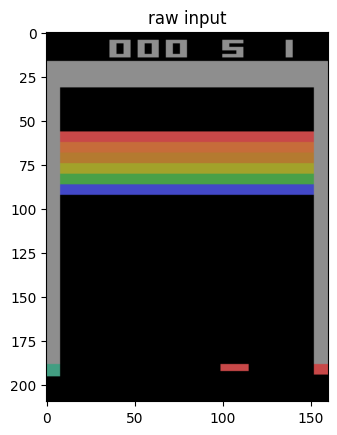

In [10]:
env=gym.make("Breakout-v0")
obs=np.array(env.reset())
print(obs[0].shape)
plt.title("raw input")
plt.imshow(obs[0])

(84, 84, 4)


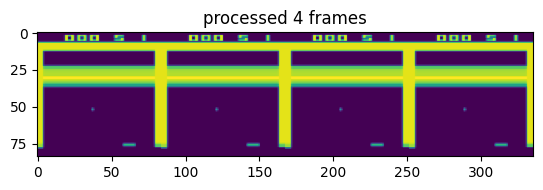

In [11]:
env=gym.make("ALE/Breakout-v5")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs=np.array(env.reset())
print(obs.shape)
plt.title("processed 4 frames")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [12]:
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


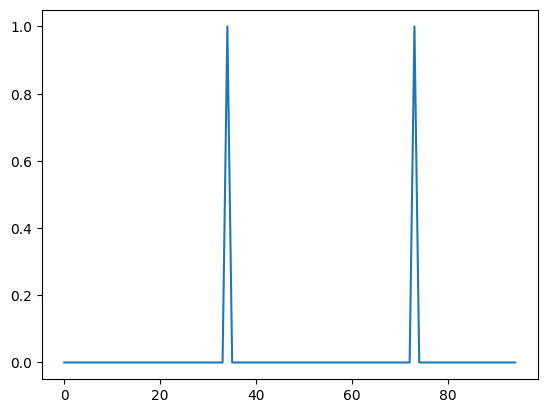

In [11]:
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

In [13]:
gamma = 0.99  

epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

epsilon_greedy_frames = 1000000.0
epsilon_random_frames = 50000

max_memory_length = 190000
batch_size = 32  
max_steps_per_episode = 10000

update_after_actions = 20
update_target_network = 10000

optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = keras.losses.Huber()

In [14]:
num_actions = 4
def create_q_model():
    inputs = layers.Input(shape=(84, 84, 4,))
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)
    return keras.Model(inputs=inputs, outputs=action)

model = create_q_model()
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

In [15]:
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
while True: 
    state = np.array(env.reset())
    episode_reward = 0
    for timestep in range(1, max_steps_per_episode):        
        frame_count += 1
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)   
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)       
        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )
            future_rewards = model_target.predict(state_next_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample
            masks = tf.one_hot(action_sample, num_actions)
            with tf.GradientTape() as tape:
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values, q_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]
        if episode_count==5:
            break
        if running_reward > 18:
          print("Solved at episode {}!".format(episode_count))
          break
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    episode_count += 1
    if running_reward > 18: 
        print("Solved at episode {}!".format(episode_count))
        break

1/1 [==============================] - 0s 39ms/step
running reward: 0.00 at episode 1, frame count 10000, epsilon 0.992, loss 0.00103
1/1 [==============================] - 0s 51ms/step
running reward: 1.50 at episode 2, frame count 20000, epsilon 0.984, loss 0.00013
1/1 [==============================] - 0s 63ms/step
running reward: 1.33 at episode 3, frame count 30000, epsilon 0.976, loss 0.00001
1/1 [==============================] - 0s 36ms/step
running reward: 1.50 at episode 4, frame count 40000, epsilon 0.968, loss 0.00003
1/1 [==============================] - 0s 46ms/step
running reward: 1.33 at episode 6, frame count 50000, epsilon 0.960, loss 0.00003
1/1 [==============================] - 0s 33ms/step


KeyboardInterrupt: ignored

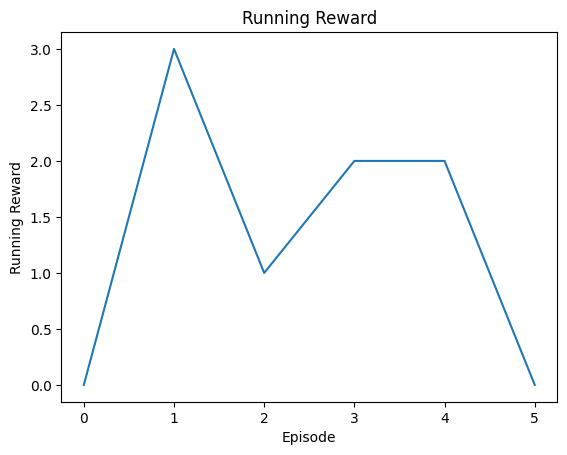

In [16]:
plt.plot(episode_reward_history)
plt.xlabel('Episode')
plt.ylabel('Running Reward')
plt.title('Running Reward')
plt.show()